In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from torch.nn.utils import prune

# Cargar modelo BERT base preentrenado y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Cargar conjunto de datos
# Este dataset contiene frases extraídas de reseñas de películas
# y está etiquetado para el análisis de sentimientos. Cada frase
# está asociada con una eitqueta que indica si el sentimiento expresado
# es positivo o negativo
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(
    lambda examples: tokenizer(examples['sentence'], truncation=True, padding='max_length'), batched=True
)

# Separar en conjuntos de entrenamiento y prueba
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["validation"]

# Función para evaluar el modelo
def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,  # El modelo que será evaluado
        eval_dataset=dataset,  # Conjunto de datos para evaluación
        tokenizer=tokenizer,
    )
    eval_results = trainer.evaluate()  # Realiza la evaluación
    return eval_results  # Devuelve las métricas de evaluación

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Evaluar modelo antes del pruning
print("Evaluación antes del pruning:")
eval_before = evaluate_model(model, test_dataset)
print(eval_before)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-71dfe692718e>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-16-71dfe692718e>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluación antes del pruning:


{'eval_loss': 0.7274540662765503, 'eval_model_preparation_time': 0.0039, 'eval_runtime': 1631.8359, 'eval_samples_per_second': 0.534, 'eval_steps_per_second': 0.067}


Para aplicar pruning en BERT, debemos reducir el número de parámetros eliminando conexiones o capas innecesarias de la red. Este enfoque puede incluir:

1. Reducción del número de capas del codificador (n_layers)
2. Reducción del número de cabezas de atención multi-cabecera (n_heads)
3. Reducción de dimensiones de embedding (d_model, d_ff)
4. Eliminación de neuronas no significativas en las capas lineales
5. Uso de técnicas de sparsity (enmascarar pesos cercanos a cero)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from torch.nn.utils import prune

# Cargar modelo BERT base preentrenado y tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Cargar conjunto de datos
# Este dataset contiene frases extraídas de reseñas de películas
# y está etiquetado para el análisis de sentimientos. Cada frase
# está asociada con una eitqueta que indica si el sentimiento expresado
# es positivo o negativo
dataset = load_dataset("glue", "sst2")
encoded_dataset = dataset.map(
    lambda examples: tokenizer(examples['sentence'], truncation=True, padding='max_length'), batched=True
)

# Separar en conjuntos de entrenamiento y prueba
train_dataset = encoded_dataset["train"]
test_dataset = encoded_dataset["validation"]

# Función para evaluar el modelo
def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,  # El modelo que será evaluado
        eval_dataset=dataset,  # Conjunto de datos para evaluación
        tokenizer=tokenizer,
    )
    eval_results = trainer.evaluate()  # Realiza la evaluación
    return eval_results  # Devuelve las métricas de evaluación

def prune_bert(model, amount=0.3, prune_type='l1_unstructured', layers_to_prune=None):

    if layers_to_prune is None:
        # Si no se especifican capas, aplicamos pruning a todas las capas lineales
        layers_to_prune = [name for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]

    print(f"Aplicando pruning con {amount*100}% de reducción utilizando {prune_type} a las siguientes capas:")
    print(layers_to_prune)

    # Iterar sobre todas las capas especificadas y aplicar pruning
    for name, module in model.named_modules():
      # Aplicamos el pruning a las capas lineales porque son las capas que concentran
      # la mayoría de los parámetros, por ello reducir el n'ú´mero depesos en estas
      # capas tienen un impacto significativo
        if name in layers_to_prune and isinstance(module, torch.nn.Linear):
            print(f"Pruning en la capa: {name} ({module.__class__.__name__})")

            # Aplicar el tipo de pruning especificado
            if prune_type == 'l1_unstructured':
                prune.l1_unstructured(module, name="weight", amount=amount)
            elif prune_type == 'random_unstructured':
                prune.random_unstructured(module, name="weight", amount=amount)
            else:
                raise ValueError(f"Tipo de pruning '{prune_type}' no soportado.")

            # Consolidar pruning eliminando la máscara y dejando solo los pesos
            prune.remove(module, "weight")

    print("Pruning completado.")

# Aplicar pruning
prune_bert(model, amount=0.3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Aplicando pruning con 30.0% de reducción utilizando l1_unstructured a las siguientes capas:
['bert.encoder.layer.0.attention.self.query', 'bert.encoder.layer.0.attention.self.key', 'bert.encoder.layer.0.attention.self.value', 'bert.encoder.layer.0.attention.output.dense', 'bert.encoder.layer.0.intermediate.dense', 'bert.encoder.layer.0.output.dense', 'bert.encoder.layer.1.attention.self.query', 'bert.encoder.layer.1.attention.self.key', 'bert.encoder.layer.1.attention.self.value', 'bert.encoder.layer.1.attention.output.dense', 'bert.encoder.layer.1.intermediate.dense', 'bert.encoder.layer.1.output.dense', 'bert.encoder.layer.2.attention.self.query', 'bert.encoder.layer.2.attention.self.key', 'bert.encoder.layer.2.attention.self.value', 'bert.encoder.layer.2.attention.output.dense', 'bert.encoder.layer.2.intermediate.dense', 'bert.encoder.layer.2.output.dense', 'bert.encoder.layer.3.attention.self.query', 'bert.encoder.layer.3.attention.self.key', 'bert.encoder.layer.3.attention.self.va

In [ ]:
# Evaluar modelo luego del pruning
print("Evaluación luego del pruning:")
eval_after = evaluate_model(model, test_dataset)
print(eval_after)

Evaluación luego del pruning:


<ipython-input-13-1c3591d57159>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.7137880921363831, 'eval_model_preparation_time': 0.0037, 'eval_runtime': 1579.4725, 'eval_samples_per_second': 0.552, 'eval_steps_per_second': 0.069}


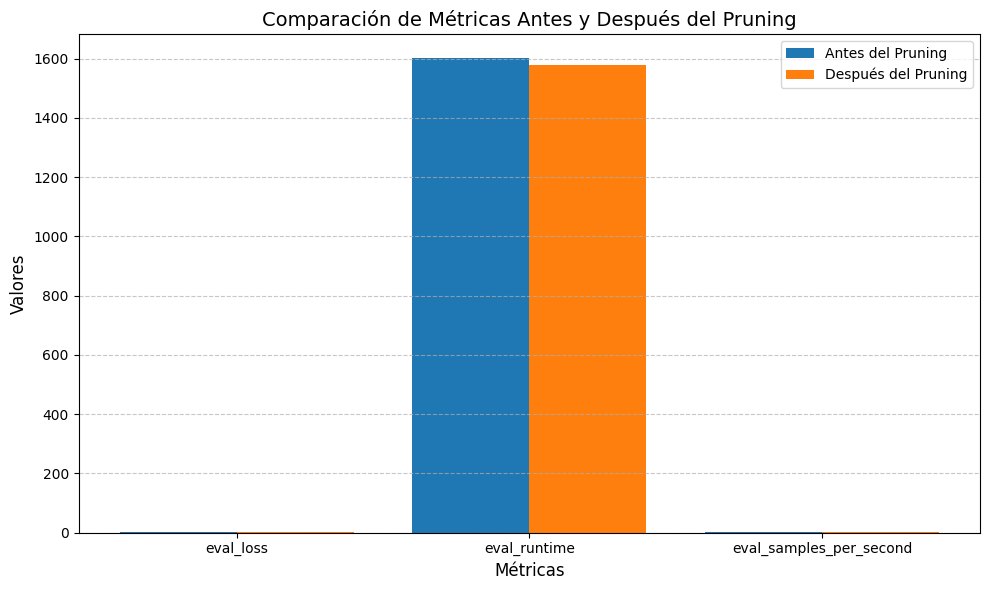

In [ ]:
import matplotlib.pyplot as plt

# Visualización de los resultados
def plot_comparison(eval_before, eval_after):
    """
    Genera un gráfico para comparar métricas antes y después del pruning.
    """
    metrics = ['eval_loss', 'eval_runtime', 'eval_samples_per_second']

    # Extraer valores para las métricas seleccionadas
    before_values = [eval_before[metric] for metric in metrics]
    after_values = [eval_after[metric] for metric in metrics]

    # Crear el gráfico
    x = range(len(metrics))
    plt.figure(figsize=(10, 6))
    plt.bar(x, before_values, width=0.4, label='Antes del Pruning', align='center')
    plt.bar([p + 0.4 for p in x], after_values, width=0.4, label='Después del Pruning', align='center')

    # Etiquetas y título
    plt.xlabel('Métricas', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.title('Comparación de Métricas Antes y Después del Pruning', fontsize=14)
    plt.xticks([p + 0.2 for p in x], metrics, fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Generar el gráfico
plot_comparison(eval_before, eval_after)

¿Qué es el ajuste post-pruning?
El ajuste post-pruning es una técnica utilizada luego de aplicar pruning a un modelo. Cuando se eliminan pesos en las capas del modelo, esto puede introducir cierta pérdida de precisión o degradación del rendimiento porque el modeloe stá siendo simplificado. Para contrarrestar esto, se realiza un proceso de ajuste fino adicional o fine-tunning para:

1. Reentrenar los parámetros restantes: Adaptar las conexiones restantes del modelo para compensar la eliminación de pesos

2. Restaurar rendimiento: Minimizar el impacto de la poda en la calidad de las predicciones

3. Mejorar generalización: Reducir el sobreajuste y mantener el modelo eficiente

Este ajuste implica entrenar nuevamente el modelo utilizando el conjunto de datos de entrenamiento, pero con un enfoque más específico y usualmente con un menor número de épocas y tasa de aprendizaje más baja

In [ ]:
# Realizar predicciones en textos nuevos
texts_to_predict = [
    "This movie was absolutely wonderful, with brilliant performances.",
    "I found the plot extremely boring and the acting terrible.",
    "An enjoyable and thought-provoking film that left a lasting impression."
]

# Función para predecir el sentimiento de múltiples textos
def predict_multiple_sentiments(model, tokenizer, texts):
    """
    Predice el sentimiento para una lista de textos usando el modelo BERT.

    Args:
        model: El modelo BERT entrenado para clasificación de sentimientos.
        tokenizer: El tokenizer correspondiente al modelo BERT.
        texts: Lista de textos para los cuales se quiere predecir el sentimiento.

    Returns:
        list: Lista de predicciones de sentimiento (1 para positivo, 0 para negativo).
    """
    predictions = []
    for text in texts:
        sentiment = predict_sentiment(model, tokenizer, text)
        # Convertir la predicción de texto a un valor binario: 1 para positivo, 0 para negativo
        pred_value = 1 if sentiment == "Positivo" else 0
        predictions.append(pred_value)
    return predictions

# Realizar predicciones en los textos nuevos
print("Realizando predicciones en textos nuevos...")
predictions = predict_multiple_sentiments(post_pruning_trainer.model, tokenizer, texts_to_predict)

# Interpretar resultados
for text, pred in zip(texts_to_predict, predictions):
    sentiment = "Positivo" if pred == 1 else "Negativo"
    print(f"Texto: {text}\nPredicción: {sentiment}\n")